In [4]:
from experiment_utils import legendre_polynomial
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

df = pd.read_csv("../datasets/STA_250_COVID19_Dataset.csv")
n_tmpts = 100
df_next_n = df.iloc[:, 4:(4 + n_tmpts)]

df_next_n.columns = [str(i) for i in range(0, n_tmpts)]

sparsity_level = 0.3
df_final = df_next_n.copy()
mask = np.random.rand(*df_final.shape) < sparsity_level
df_final[mask] = np.nan

# Convert to NumPy array
subject_count = 1
legendre_polynomial_index = 3
time_values = np.linspace(0, 1, n_tmpts)
X = df_final.head(subject_count).to_numpy() * legendre_polynomial(legendre_polynomial_index)(time_values)
T = np.stack([time_values for i in range(X.shape[0])])
plt.plot(T[0], X[0], "o")

ModuleNotFoundError: No module named 'experiment_utils'

In [18]:
from neuralint import NeuralInt
from data_utils import get_dataloaders
from model_utils import load_model, train

dataloaders = get_dataloaders(T, X, train_split=1, val_split=0)
model = NeuralInt(input_dim=X.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-8)
epoch, loss = load_model(model, optimizer=optimizer, checkpoint_dir=f"model_checkpoints/checkpoints_covid_coeff_{legendre_polynomial_index}")
train(model, optimizer, dataloaders["train"], dataloaders["validate"], num_epochs=1000, starting_epoch = epoch, best_val_loss = loss, checkpoint_dir=f"model_checkpoints/checkpoints_covid_coeff_{legendre_polynomial_index}")

C:\Users\sripk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataset.py:473: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(
C:\Users\sripk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataset.py:473: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(
C:\Users\sripk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Starting training at epoch 1/1000, Validation Loss: inf
Epoch 1/1000, Training Loss: 11.7198410
Checkpoint saved: model_checkpoints/checkpoints_covid_coeff_3\checkpoint_epoch_1.pth
Best model saved: model_checkpoints/checkpoints_covid_coeff_3\best_model.pth
Epoch 2/1000, Training Loss: 10.2438641
Best model saved: model_checkpoints/checkpoints_covid_coeff_3\best_model.pth
Epoch 3/1000, Training Loss: 8.2119293
Best model saved: model_checkpoints/checkpoints_covid_coeff_3\best_model.pth
Epoch 4/1000, Training Loss: 7.8419271
Best model saved: model_checkpoints/checkpoints_covid_coeff_3\best_model.pth
Epoch 5/1000, Training Loss: 7.3724213
Best model saved: model_checkpoints/checkpoints_covid_coeff_3\best_model.pth
Epoch 6/1000, Training Loss: 7.1249681
Best model saved: model_checkpoints/checkpoints_covid_coeff_3\best_model.pth
Epoch 7/1000, Training Loss: 6.8888388
Best model saved: model_checkpoints/checkpoints_covid_coeff_3\best_model.pth
Epoch 8/1000, Training Loss: 6.7723398
Best m

KeyboardInterrupt: 

In [19]:
from neuralint import get_imputation_from_checkpoint

subset = dataloaders["train"].dataset
T_test, X_test, _ = subset.dataset[subset.indices]

X_imputed_transformer, X_imputed_neuralint, integration_fn = get_imputation_from_checkpoint(T_test, X_test, checkpoint_dir=f"model_checkpoints/checkpoints_covid_coeff_{legendre_polynomial_index}")

Loaded model checkpoint with epoch: 657, and validation loss: 0.019560743123292923


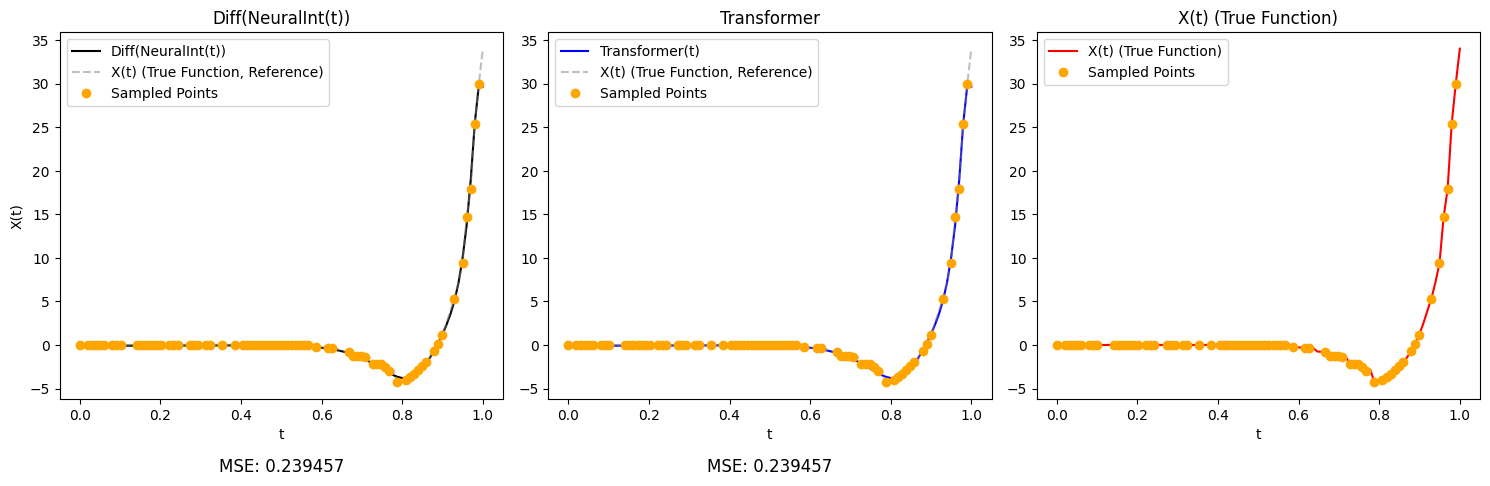

In [21]:
legendre = legendre_polynomial(legendre_polynomial_index)(time_values)
np_imputed_neuralint = X_imputed_neuralint[0].detach().numpy()
actual = df_next_n.to_numpy()[0] * legendre
points = X[0]
# Compute MSE using PyTorch
mse_neuralint = torch.nn.functional.mse_loss(
    torch.tensor(np_imputed_neuralint), torch.tensor(actual)
).item()

mse_transformer = torch.nn.functional.mse_loss(
    torch.tensor(np_imputed_neuralint), torch.tensor(actual)
).item()

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot NeuralInt with reference to True Function
axes[0].plot(time_values, np_imputed_neuralint, color="black", label="Diff(NeuralInt(t))")
axes[0].plot(time_values, actual, linestyle="dashed", color="gray", alpha=0.5, label="X(t) (True Function, Reference)")
axes[0].plot(time_values, points, "o", color="orange", label="Sampled Points")
axes[0].set_title("Diff(NeuralInt(t))")
axes[0].set_xlabel("t")
axes[0].set_ylabel("X(t)")
axes[0].legend()
axes[0].text(0.5, -0.2, f"MSE: {mse_neuralint:.6f}", ha='center', transform=axes[0].transAxes, fontsize=12)

# Plot Transformer with reference to True Function
axes[1].plot(time_values, np_imputed_neuralint, color="blue", label="Transformer(t)")
axes[1].plot(time_values, actual, linestyle="dashed", color="gray", alpha=0.5, label="X(t) (True Function, Reference)")
axes[1].plot(time_values, points, "o", color="orange", label="Sampled Points")
axes[1].set_title("Transformer")
axes[1].set_xlabel("t")
axes[1].legend()
axes[1].text(0.5, -0.2, f"MSE: {mse_transformer:.6f}", ha='center', transform=axes[1].transAxes, fontsize=12)

# Plot Actual Function with references to NeuralInt and Transformer
axes[2].plot(time_values, actual, color="red", label="X(t) (True Function)")
axes[2].plot(time_values, points, "o", color="orange", label="Sampled Points")
axes[2].set_title("X(t) (True Function)")
axes[2].set_xlabel("t")
axes[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


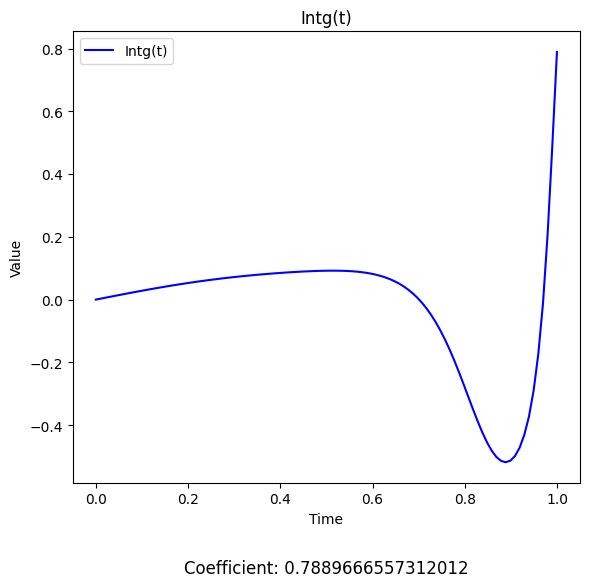

0.78896666


In [22]:
# Convert PyTorch tensor to NumPy for plotting
int_fn = integration_fn[0].detach().numpy()

# Plot both functions side by side
fig, axs = plt.subplots(1, 1, figsize=(6,6))

# Plot Mean Integration Function with faded dashed True Integral
axs.plot(time_values, int_fn, label="Intg(t)", color="blue")
axs.set_title("Intg(t)")
axs.set_xlabel("Time")
axs.set_ylabel("Value")
axs.text(0.5, -0.2, f"Coefficient: {int_fn[-1]}", ha='center', transform=axs.transAxes, fontsize=12)
axs.legend()

# Show the plots
plt.tight_layout()
plt.show()
print(int_fn[-1])


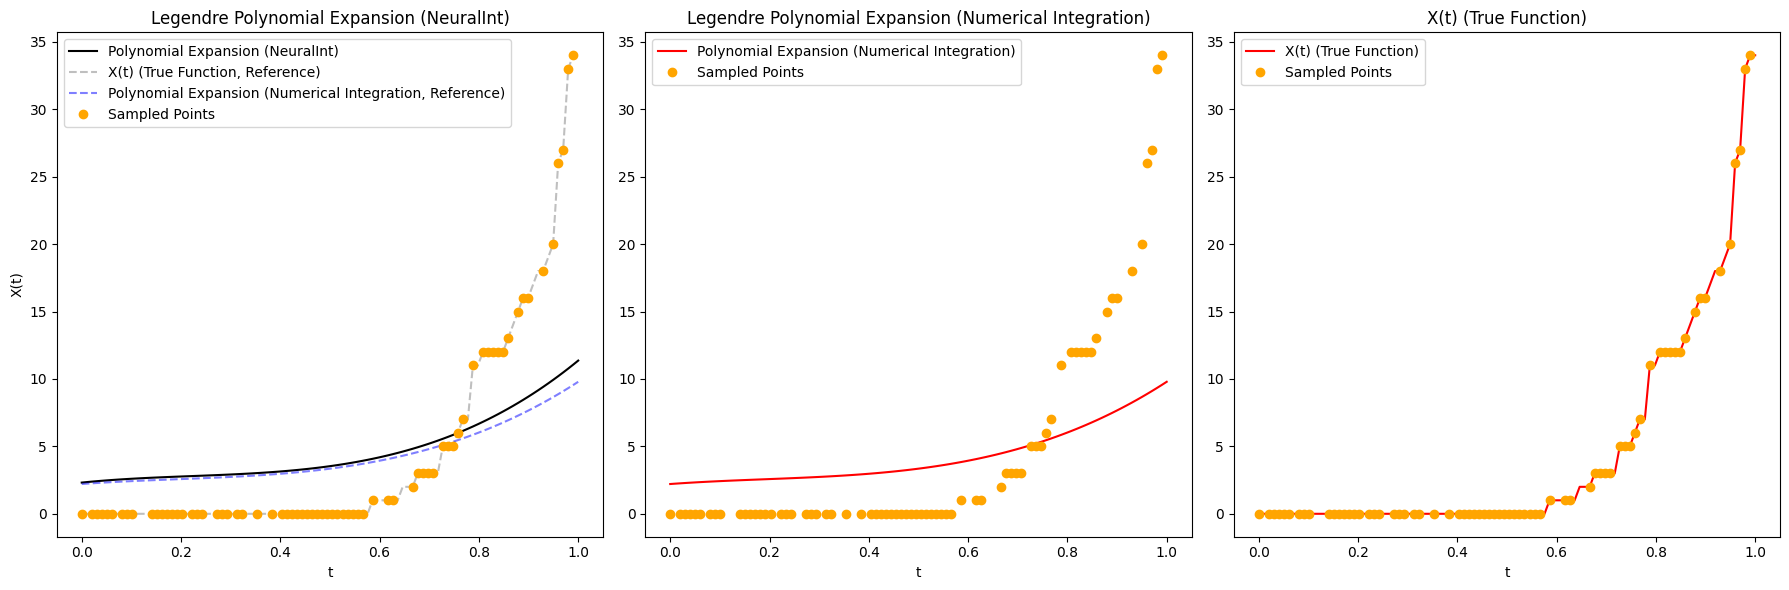

In [39]:
from experiment_utils import legendre_from_coefficients, estimate_riemann_integral

legendre_estimate = legendre_from_coefficients([4.6340947, 3.7340016, 2.2032728, 0.78896666])(time_values)

original_data = df_final.head(subject_count).to_numpy()[0]
coeffs = np.zeros(len(original_data))
for i in range(4):
    coeffs[i] = estimate_riemann_integral(original_data * legendre_polynomial(i)(time_values))
estimate = legendre_from_coefficients(coeffs)

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(time_values, legendre_estimate, color="black", label="Polynomial Expansion (NeuralInt)")
axes[0].plot(time_values, actual / legendre, linestyle="dashed", color="gray", alpha=0.5, label="X(t) (True Function, Reference)")
axes[0].plot(time_values, estimate(time_values), linestyle="dashed", color="blue", alpha=0.5, label="Polynomial Expansion (Numerical Integration, Reference)")
axes[0].plot(time_values, X[0] / legendre, "o", color="orange", label="Sampled Points")
axes[0].set_title("Legendre Polynomial Expansion (NeuralInt)")
axes[0].set_xlabel("t")
axes[0].set_ylabel("X(t)")
axes[0].legend()

axes[1].plot(time_values, estimate(time_values), color="red", label="Polynomial Expansion (Numerical Integration)")
axes[1].plot(time_values, X[0] / legendre, "o", color="orange", label="Sampled Points")
axes[1].set_title("Legendre Polynomial Expansion (Numerical Integration)")
axes[1].set_xlabel("t")
axes[1].legend()

axes[2].plot(time_values, actual / legendre, color="red", label="X(t) (True Function)")
axes[2].plot(time_values, X[0] / legendre, "o", color="orange", label="Sampled Points")
axes[2].set_title("X(t) (True Function)")
axes[2].set_xlabel("t")
axes[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()